In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, pairwise_distances
from gap_statistic import OptimalK
import matplotlib.pyplot as plt

/opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import pairwise_distances
import seaborn as sns
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, LeakyReLU

In [3]:
data=pd.read_csv("expression_matrix1.csv", index_col=0)
data_t = np.transpose(data)
coordinates=pd.read_csv("tissue_positions_list_aligned.csv")
coordinates_new = coordinates[['V3', 'V4']].values
genes=data_t

In [5]:
genes.shape

(2698, 31053)

In [6]:
# Standardize the gene expression data
scaler = StandardScaler()
genes_scaled = scaler.fit_transform(genes)
# Calculate the variance of each gene
gene_variances = genes_scaled.var(axis=0)
gene_variances_df=pd.DataFrame(gene_variances)
gene_variances_df = gene_variances_df.reset_index()
gene_variances_df.columns = ['gene', 'variance']
gene_variances_df.index = genes.columns
# Select the top 10,000 highly variable genes
top_10000_genes = gene_variances_df.nlargest(10000, 'variance').index
genes_scaled_df = pd.DataFrame(genes_scaled)
genes_scaled_df.index=genes.index
genes_scaled_df.columns=genes.columns
# Extract the data for the top 10,000 genes
highly_variable_genes_data = genes_scaled_df[top_10000_genes]
# Reshape for the CAE input
n_samples, n_genes = highly_variable_genes_data.shape
n_samples, n_genes
highly_variable_genes_data_mtx = highly_variable_genes_data.to_numpy()

In [7]:
# Extract the data for the top 10,000 genes
highly_variable_genes_data = genes_scaled_df[top_10000_genes]
# Reshape for the CAE input
n_samples, n_genes = highly_variable_genes_data.shape
n_samples, n_genes
highly_variable_genes_data_mtx = highly_variable_genes_data.to_numpy()
#genes_reshaped = highly_variable_genes_data_mtx.reshape((n_samples, int(np.sqrt(n_genes)), int(np.sqrt(n_genes)), 1))
genes_reshaped = highly_variable_genes_data_mtx.reshape(n_samples, 100, 100, 1)

In [8]:
# Step 2: Define the Convolutional Autoencoder
#input_img = Input(shape=(int(np.sqrt(n_genes)), int(np.sqrt(n_genes)), 1))
input_img = Input(shape=(int(100), int(100), 1))

In [9]:
# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [10]:
# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [11]:
# Autoencoder model with mae
autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='mae')

In [12]:
# Train the autoencoder with mae loss
autoencoder.fit(genes_reshaped, genes_reshaped, epochs=10, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.6177 - val_loss: 0.5370
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.5207 - val_loss: 0.5350
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.5223 - val_loss: 0.5347
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 0.5151 - val_loss: 0.5347
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.5195 - val_loss: 0.5347
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.5225 - val_loss: 0.5347
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.5186 - val_loss: 0.5347
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.5247 - val_loss: 0.5347
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.5209 - val_loss: 0.5347
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.5221 - val_loss: 0.5347


In [13]:
# Encoder model to extract the encoded features
encoder = Model(input_img, encoded)

In [14]:
# Step 3: Encode the data using the CAE
encoded_genes = encoder.predict(genes_reshaped)
encoded_genes_flat = encoded_genes.reshape((n_samples, -1))

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


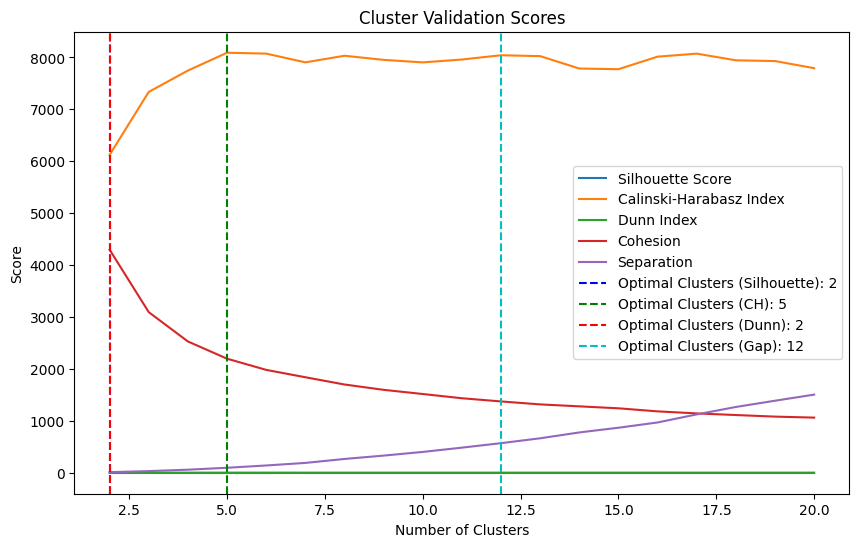

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on Calinski-Harabasz Index: 5
Optimal number of clusters based on Dunn Index: 2
Optimal number of clusters based on Gap Statistic: 12


In [15]:
# Flatten the encoded data for clustering
#encoded_data_flat = encoded_data.reshape((encoded_data.shape[0], -1))

# Concatenate the encoded data with coordinates for clustering
#data_for_clustering = np.hstack((encoded_data_flat, coordinates_matrix))
#data_for_clustering = np.hstack((encoded_genes_flat, coordinates_new))
data_for_clustering =encoded_genes_flat
# Dimensionality reduction using UMAP
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(data_for_clustering)

# Function to calculate validation indices for a range of cluster numbers
def calculate_indices(data, max_clusters):
    sil_scores = []
    ch_scores = []
    dunn_scores = []
    cohesion_scores = []
    separation_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=123)
        labels = kmeans.fit_predict(data)
        
        sil_scores.append(silhouette_score(data, labels))
        ch_scores.append(calinski_harabasz_score(data, labels))
        dunn_scores.append(dunn_index(data, labels))
        cohesion, separation = cohesion_separation(data, labels)
        cohesion_scores.append(cohesion)
        separation_scores.append(separation)
    
    return sil_scores, ch_scores, dunn_scores, cohesion_scores, separation_scores

# Dunn Index calculation
def dunn_index(data, labels):
    distances = pairwise_distances(data)
    unique_labels = np.unique(labels)
    
    intra_dists = np.zeros(len(unique_labels))
    for k in range(len(unique_labels)):
        cluster_k = data[labels == unique_labels[k]]
        intra_dists[k] = np.mean(pairwise_distances(cluster_k))
        
    inter_dists = np.zeros((len(unique_labels), len(unique_labels)))
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            inter_dists[i, j] = np.min(pairwise_distances(data[labels == unique_labels[i]], data[labels == unique_labels[j]]))
    
    return np.min(inter_dists) / np.max(intra_dists)

# Cohesion and Separation calculation
def cohesion_separation(data, labels):
    cohesion = 0
    separation = 0
    unique_labels = np.unique(labels)
    
    for k in unique_labels:
        cluster_k = data[labels == k]
        centroid_k = np.mean(cluster_k, axis=0)
        cohesion += np.sum(np.linalg.norm(cluster_k - centroid_k, axis=1))
        
    for i in unique_labels:
        for j in unique_labels:
            if i != j:
                centroid_i = np.mean(data[labels == i], axis=0)
                centroid_j = np.mean(data[labels == j], axis=0)
                separation += np.linalg.norm(centroid_i - centroid_j)
    
    return cohesion, separation

# Determine the optimal number of clusters using various indices
max_clusters = 20  # You can adjust this value
sil_scores, ch_scores, dunn_scores, cohesion_scores, separation_scores = calculate_indices(umap_result, max_clusters)

# Gap Statistic calculation
optimalK = OptimalK(parallel_backend='joblib')
n_clusters_gap = optimalK(umap_result, cluster_array=np.arange(1, max_clusters + 1))

# Determine optimal number of clusters based on the best index scores
optimal_clusters_sil = np.argmax(sil_scores) + 2
optimal_clusters_ch = np.argmax(ch_scores) + 2
optimal_clusters_dunn = np.argmax(dunn_scores) + 2
optimal_clusters_gap = n_clusters_gap

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), sil_scores, label='Silhouette Score')
plt.plot(range(2, max_clusters + 1), ch_scores, label='Calinski-Harabasz Index')
plt.plot(range(2, max_clusters + 1), dunn_scores, label='Dunn Index')
plt.plot(range(2, max_clusters + 1), cohesion_scores, label='Cohesion')
plt.plot(range(2, max_clusters + 1), separation_scores, label='Separation')
plt.axvline(optimal_clusters_sil, linestyle='--', color='b', label=f'Optimal Clusters (Silhouette): {optimal_clusters_sil}')
plt.axvline(optimal_clusters_ch, linestyle='--', color='g', label=f'Optimal Clusters (CH): {optimal_clusters_ch}')
plt.axvline(optimal_clusters_dunn, linestyle='--', color='r', label=f'Optimal Clusters (Dunn): {optimal_clusters_dunn}')
plt.axvline(optimal_clusters_gap, linestyle='--', color='c', label=f'Optimal Clusters (Gap): {optimal_clusters_gap}')
plt.legend()
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Cluster Validation Scores')
plt.show()

# Print the optimal number of clusters based on different indices
print(f'Optimal number of clusters based on Silhouette Score: {optimal_clusters_sil}')
print(f'Optimal number of clusters based on Calinski-Harabasz Index: {optimal_clusters_ch}')
print(f'Optimal number of clusters based on Dunn Index: {optimal_clusters_dunn}')
print(f'Optimal number of clusters based on Gap Statistic: {optimal_clusters_gap}')


In [17]:
#nice color visualization
import colorcet as cc

/var/folders/m0/zfhtc0j11sg1h0cfrfzqlc3w0000gn/T/ipykernel_15407/1257480005.py:9: UserWarning: The palette list has more values (25) than needed (5), which may not be intended.
  sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=labels, palette=palette, s=50)


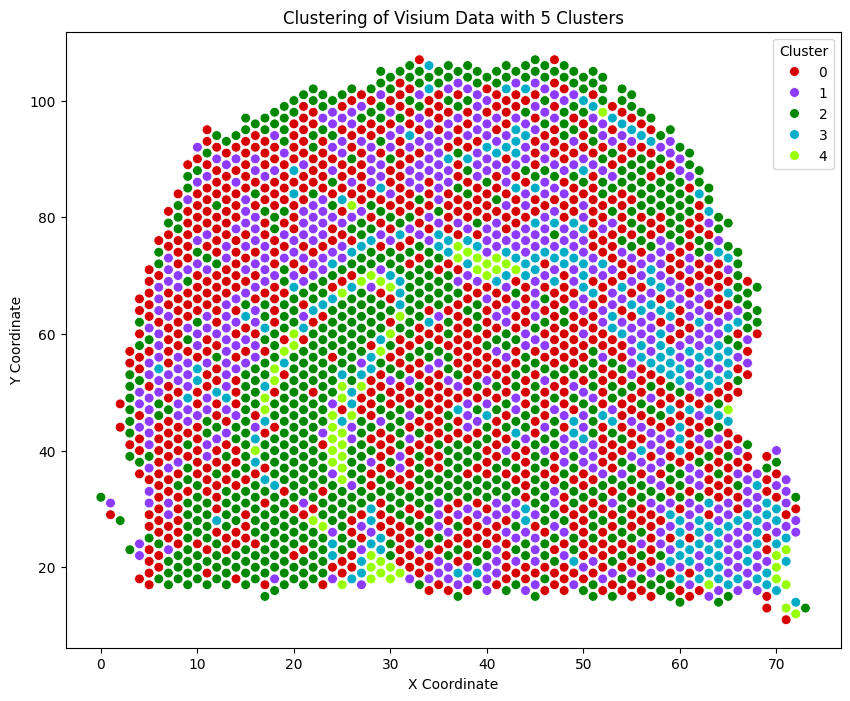

In [26]:
# Step 5: Determine the optimum number of clusters
optimum_clusters = range(2, 21)[np.argmax(ch_scores)]
#optimum_clusters=n_clusters_gap
kmeans = KMeans(n_clusters=optimum_clusters, random_state=42).fit(encoded_genes_flat)
labels = kmeans.labels_
palette = sns.color_palette(cc.glasbey, n_colors=25)
# Step 6: Plot the clusters based on coordinates
plt.figure(figsize=(10, 8))
sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=labels, palette=palette, s=50)
plt.title(f'Clustering of Visium Data with {optimum_clusters} Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.show()

Gamma Mixture Variational Autoencoder For Clustering High-Dimensional Right-Skewed Data 

In [27]:
# Standardize the gene expression data
scaler = MinMaxScaler()
genes_scaled = scaler.fit_transform(genes)
# Calculate the variance of each gene
gene_variances = genes_scaled.var(axis=0)
gene_variances_df=pd.DataFrame(gene_variances)
gene_variances_df = gene_variances_df.reset_index()
gene_variances_df.columns = ['gene', 'variance']
gene_variances_df.index = genes.columns
# Select the top 30,000 highly variable genes
top_30000_genes = gene_variances_df.nlargest(31053, 'variance').index
genes_scaled_df = pd.DataFrame(genes_scaled)
genes_scaled_df.index=genes.index
genes_scaled_df.columns=genes.columns
# Extract the data for the top 10,000 genes
highly_variable_genes_data = genes_scaled_df[top_30000_genes]
# Reshape for the CAE input
n_samples, n_genes = highly_variable_genes_data.shape
n_samples, n_genes
highly_variable_genes_data_mtx = highly_variable_genes_data.to_numpy()

In [28]:
np.min(highly_variable_genes_data_mtx), np.max(highly_variable_genes_data_mtx)

(0.0, 1.0000000000000002)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class Sampling(nn.Module):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def forward(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

class GMVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, gamma_shape, gamma_scale):
        super(GMVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.gamma_shape = torch.tensor(gamma_shape)
        self.gamma_scale = torch.tensor(gamma_scale)

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.z_mean = nn.Linear(512, latent_dim)
        self.z_log_var = nn.Linear(512, latent_dim)

        # Sampling layer
        self.sampling = Sampling()

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z_mean, z_log_var, z = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, z_mean, z_log_var, z

def gamma_log_pdf(x, shape, scale):
    return (shape - 1) * torch.log(x) - (x / scale) - torch.lgamma(shape) - shape * torch.log(scale)

def loss_function(recon_x, x, z_mean, z_log_var, z, gamma_shape, gamma_scale):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    gamma_log_pdf_val = gamma_log_pdf(torch.exp(z), gamma_shape, gamma_scale)
    gamma_loss = -torch.sum(gamma_log_pdf_val)
    return BCE + KLD + gamma_loss

def train_model(model, dataloader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(dataloader):
            data = data[0]  # Get the input data from the tuple
            optimizer.zero_grad()
            recon_batch, z_mean, z_log_var, z = model(data)
            loss = loss_function(recon_batch, data, z_mean, z_log_var, z, model.gamma_shape, model.gamma_scale)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset)}')

# Example usage
input_dim = 31053  # Adjusted for the given data dimensions
latent_dim = 10
gamma_shape = 2.0
gamma_scale = 2.0
batch_size = 32
epochs = 100
learning_rate = 0.001

# Generate synthetic data
np.random.seed(42)
#x_train = np.random.rand(1000, input_dim).astype(np.float32)  # 1000 samples, 31053 features
x_train = highly_variable_genes_data_mtx.astype(np.float32)  # 2698 samples, 31053 features
train_dataset = TensorDataset(torch.tensor(x_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = GMVAE(input_dim, latent_dim, gamma_shape, gamma_scale)
train_model(model, train_dataloader, epochs, learning_rate)

# Get latent representations
model.eval()
with torch.no_grad():
    z_mean, z_log_var, z = model.encode(torch.tensor(x_train))
    latent_representations = z_mean.numpy()

print(latent_representations[:5])  # Display the first 5 latent representations as a sample


Epoch 1, Loss: 374860.0835413385
Epoch 2, Loss: 3489.5972667832652
Epoch 3, Loss: 3457.8715201364435
Epoch 4, Loss: 3442.0257851591455
Epoch 5, Loss: 3432.6806416211084
Epoch 6, Loss: 3424.9339412296144
Epoch 7, Loss: 3417.8298899068755
Epoch 8, Loss: 3411.8370754957377
Epoch 9, Loss: 3407.1241805272425
Epoch 10, Loss: 3402.3540614575613
Epoch 11, Loss: 3398.526934013621
Epoch 12, Loss: 3396.6914250718123
Epoch 13, Loss: 3394.0513263586454
Epoch 14, Loss: 3390.982808446071
Epoch 15, Loss: 3386.9627212286878
Epoch 16, Loss: 3382.2309219213307
Epoch 17, Loss: 3379.6105607741847
Epoch 18, Loss: 3378.937399375695
Epoch 19, Loss: 3378.276548890382
Epoch 20, Loss: 3373.848989703021
Epoch 21, Loss: 3369.2498798299666
Epoch 22, Loss: 3367.037178147007
Epoch 23, Loss: 3365.247515520756
Epoch 24, Loss: 3372.308619810971
Epoch 25, Loss: 3365.50030983599
Epoch 26, Loss: 3361.119598863742
Epoch 27, Loss: 3360.521824615456
Epoch 28, Loss: 3356.043456669292
Epoch 29, Loss: 3352.8684275678743
Epoch 30

In [30]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import colorcet as cc

/var/folders/m0/zfhtc0j11sg1h0cfrfzqlc3w0000gn/T/ipykernel_15407/4269566188.py:23: UserWarning: The palette list has more values (25) than needed (4), which may not be intended.
  sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters, palette=palette, s=50)


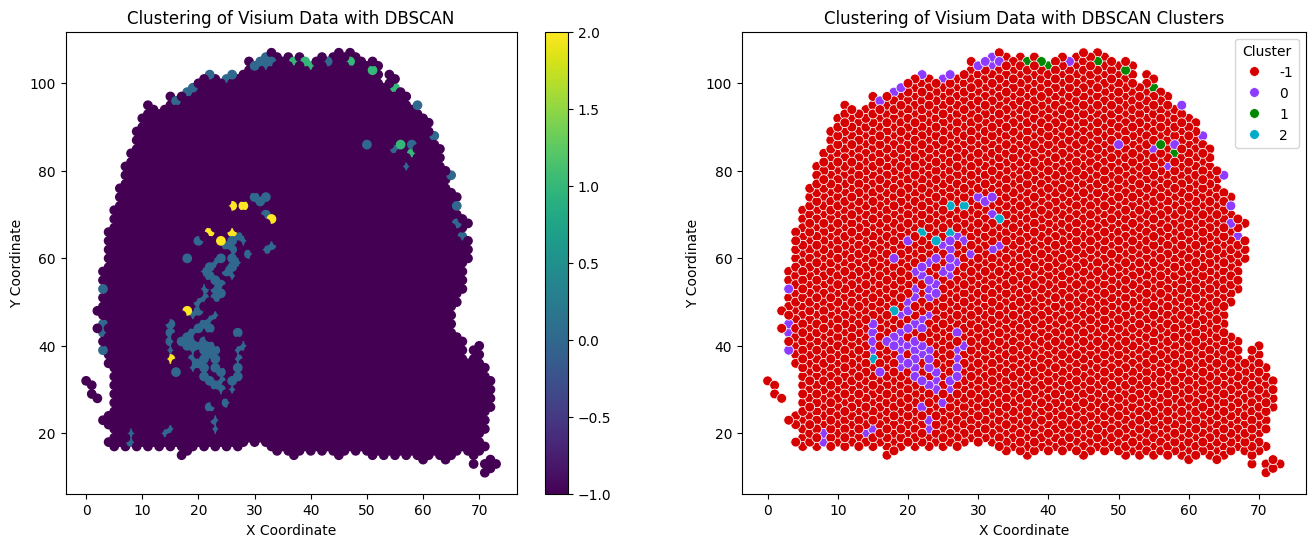

In [56]:
# Perform DBSCAN clustering on latent representations
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(latent_representations)

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

# Alternative visualization using t-SNE
# tsne = TSNE(n_components=2)
# latent_2d = tsne.fit_transform(latent_representations)

# Visualize the clusters
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

scatter = plt.scatter(coordinates_new[:, 0], coordinates_new[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('Clustering of Visium Data with DBSCAN')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.subplot(1, 2, 2)
sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters, palette=palette, s=50)
plt.title(f'Clustering of Visium Data with DBSCAN Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.show()

/var/folders/m0/zfhtc0j11sg1h0cfrfzqlc3w0000gn/T/ipykernel_15407/1285363611.py:21: UserWarning: The palette list has more values (25) than needed (10), which may not be intended.
  sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters_spectral, palette=palette, s=50)


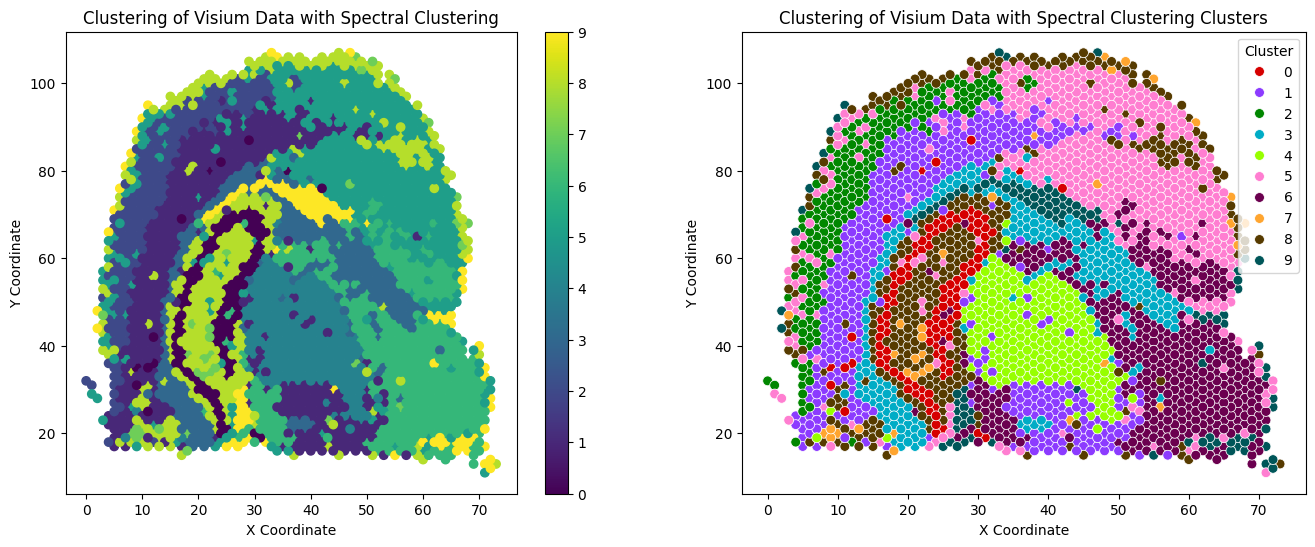

In [57]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

# Perform Spectral Clustering on latent representations
spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors')
clusters_spectral = spectral.fit_predict(latent_representations)
palette = sns.color_palette(cc.glasbey, n_colors=25)
# Visualize the clusters

# Visualize the clusters
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

scatter = plt.scatter(coordinates_new[:, 0], coordinates_new[:, 1], c=clusters_spectral, cmap='viridis')
plt.colorbar(scatter)
plt.title('Clustering of Visium Data with Spectral Clustering')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.subplot(1, 2, 2)

sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters_spectral, palette=palette, s=50)
plt.title(f'Clustering of Visium Data with Spectral Clustering Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.show()

/var/folders/m0/zfhtc0j11sg1h0cfrfzqlc3w0000gn/T/ipykernel_15407/1289098906.py:19: UserWarning: The palette list has more values (25) than needed (10), which may not be intended.
  sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters_agglo, palette=palette, s=50)


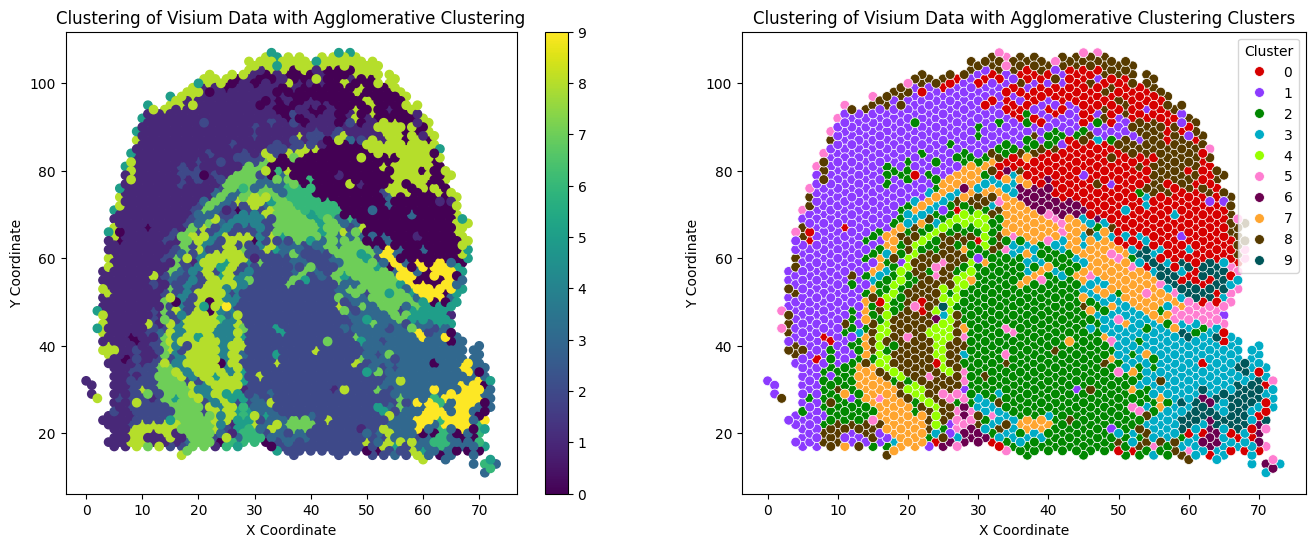

In [58]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering on latent representations
agglo = AgglomerativeClustering(n_clusters=10)
clusters_agglo = agglo.fit_predict(latent_representations)

# Visualize the clusters

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

scatter = plt.scatter(coordinates_new[:, 0], coordinates_new[:, 1], c=clusters_agglo, cmap='viridis')
plt.colorbar(scatter)
plt.title('Clustering of Visium Data with Agglomerative Clustering')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.subplot(1, 2, 2)

sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters_agglo, palette=palette, s=50)
plt.title(f'Clustering of Visium Data with Agglomerative Clustering Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.show()

/var/folders/m0/zfhtc0j11sg1h0cfrfzqlc3w0000gn/T/ipykernel_15407/3364454800.py:18: UserWarning: The palette list has more values (25) than needed (3), which may not be intended.
  sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters_hdbscan, palette=palette, s=50)


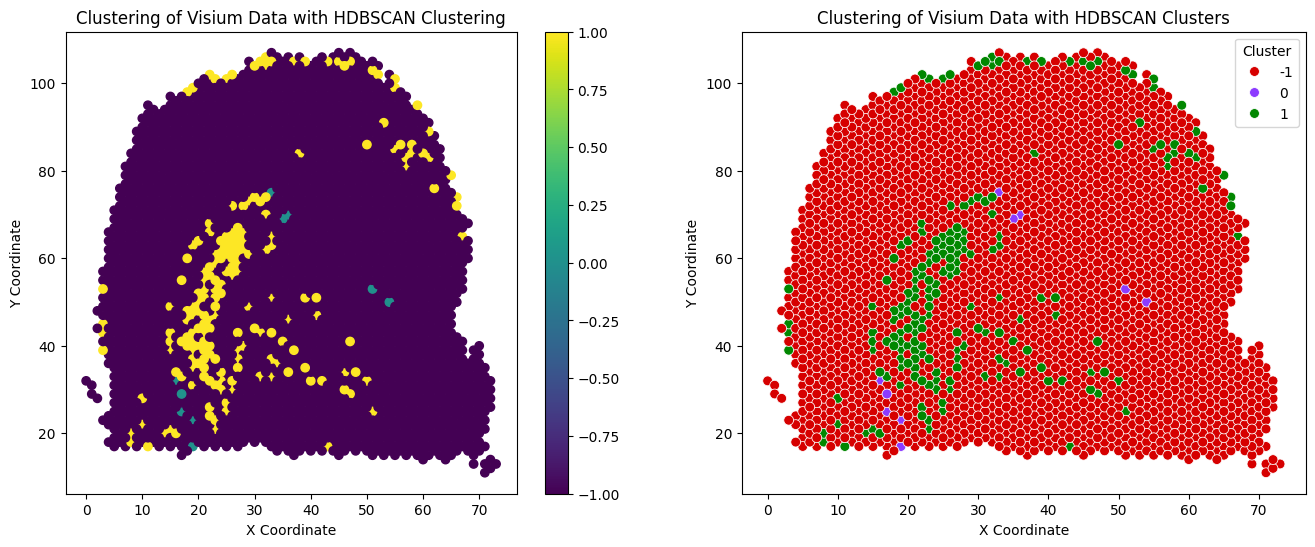

In [59]:
import hdbscan

# Perform HDBSCAN clustering on latent representations
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusters_hdbscan = hdbscan_clusterer.fit_predict(latent_representations)

# Visualize the clusters

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(coordinates_new[:, 0], coordinates_new[:, 1], c=clusters_hdbscan, cmap='viridis')
plt.colorbar(scatter)
plt.title('Clustering of Visium Data with HDBSCAN Clustering')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.subplot(1, 2, 2)

sns.scatterplot(x=coordinates_new[:, 0], y=coordinates_new[:, 1], hue=clusters_hdbscan, palette=palette, s=50)
plt.title(f'Clustering of Visium Data with HDBSCAN Clusters')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster')
plt.show()
